In [1]:
import json

import pyleoclim as pyleo
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so


from pylipd.lipd import LiPD
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch


## FROM KRL: Also import matplotlib.pyplot for additional figure-making capabilities
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import ticker

plt.rcParams['pdf.fonttype'] = 42  # changes font type so that vector graphics software (i.e. Adobe Illustrator) recognizes text
plt.rcParams['font.family'] = "Arial"  # changes font type to Arial; Illustrator on Windows doesn't work well with default Pyplot font

In [2]:
#import data
#All data should be in the working folder
LIS = pd.read_csv('Dalton_2023_LISsize.csv')
LIS['Age']=LIS['Age']*1000
LIS['midpoint age for 1st derivative']=LIS['midpoint age for 1st derivative']*1000
LIS

,Age,"Areal extent, 10^6 km^2","1st derivative of areal extent, 10^6 km^2/yr",midpoint age for 1st derivative
0,1000.0,0.1,NaN,NaN
1,1500.0,0.1,0.0,1250.0
2,2000.0,0.1,0.0,1750.0
3,2500.0,0.1,0.0,2250.0
4,3000.0,0.1,0.0,2750.0
5,3500.0,0.1,0.0,3250.0
6,4000.0,0.1,0.0,3750.0
7,4500.0,0.1,0.0,4250.0
8,5000.0,0.1,0.0,4750.0
9,5500.0,0.1,0.0,5250.0


In [99]:
#import data
#All data should be in the working folder
EIS = pd.read_csv('/Users/elizabeth/Imandra/Hughes_2016_EISArea.csv')
EIS['Age']=EIS['Age']*1000
EIS

,Age,EIS_Size
0,38000,0.23
1,34000,0.23
2,32000,1.58
3,30000,1.58
4,29000,2.16
5,28000,2.17
6,27000,3.61
7,25000,3.95
8,24000,4.75
9,23000,5.18


# Ensemble Series creation function

Here we define the function we'll use to create ensembles. We'll require that the user pass in a vector for paleo data values, a vector for depth related to the paleo data, an ensemble table, and a vector for depth related to the ensemble table. The first dimension of the paleo data values and the first dimension of the paleo depth vector should be the same. The same goes for the age ensemble depth vector and the age ensemble matrix. Feel free to copy and use this function at will!

In [111]:
def mapAgeEnsembleToPaleoData(ensembleValues, paleoValues, ensembleDepth, paleoDepth,
                             value_name = None,value_unit = None,time_name = None,time_unit = None):
    """ Map the depth for the ensemble age values to the paleo values

    Parameters
    ----------

    ensembleValues : array
        A matrix of possible age models. Realizations
        should be stored in columns
        
    paleoValues : 1D array
        A vector containing the paleo data values. The vector
        should have the same length as depthPaleo
        
    ensembleDepth : 1D array
        A vector of depth. The vector should have the same
        length as the number of rows in the ensembleValues
        
    paleoDepth : 1D array
        A vector corresponding to the depth at which there
        are paleodata information
        
    value_name : str
        Paleo data value name
    
    value_unit : str
        Paleo data value unit
    
    time_name : str
        Time name
    
    time_unit : str
        Time unit

    Returns
    -------

    ensemble : pyleoclim.EnsembleSeries
        A matrix of age ensemble on the PaleoData scale

    """

    #Make sure that numpy arrays were given and try to coerce them into vectors if possible
    ensembleDepth=np.squeeze(np.array(ensembleDepth))
    paleoValues = np.squeeze(np.array(paleoValues))
    paleoDepth = np.squeeze(np.array(paleoDepth))

    #Check that arrays are vectors for np.interp
    if paleoValues.ndim > 1:
        raise ValueError('ensembleValues has more than one dimension, please pass it as a 1D array')
    if ensembleDepth.ndim > 1:
        raise ValueError('ensembleDepth has more than one dimension, please pass it as a 1D array')
    if paleoDepth.ndim > 1:
        raise ValueError('paleoDepth has more than one dimension, please pass it as a 1D array')

    if len(ensembleDepth)!=np.shape(ensembleValues)[0]:
        raise ValueError("Ensemble depth and age need to have the same length")
        
    if len(paleoValues) != len(paleoDepth):
        raise ValueError("Paleo depth and age need to have the same length")

    #Interpolate
    ensembleValuesToPaleo = np.zeros((len(paleoDepth),np.shape(ensembleValues)[1])) #placeholder
    
    for i in np.arange(0,np.shape(ensembleValues)[1]):
        ensembleValuesToPaleo[:,i]=np.interp(paleoDepth,ensembleDepth,ensembleValues[:,i])
    
    series_list = []
    
    for s in ensembleValuesToPaleo.T:
        series_tmp = pyleo.Series(time=s, value=paleoValues,
                       verbose=False,
                       clean_ts=False,
                       value_name=value_name,
                       value_unit=value_unit,
                       time_name=time_name,
                       time_unit=time_unit)
        series_list.append(series_tmp)
    
    ensemble = pyleo.EnsembleSeries(series_list=series_list)

    return ensemble

## Define function 'getlipd()' for importing LiPD data

# Arguments + Keyword Arguments:
# filename = name of LiPD file
# paleoData_variableName = column name of variable being imported
# depth_name = column name of depth variable (for using depths in multiple paleoData tables)
# val_unit = unit of the paleoData variable being imported
# ens_num = index of paleo data table containing the imported variable, set to 0 by default

# Function returns:
# ensemble = LiPD age ensemble mapped to selected paleoData returned by the
# 'mapAgeEnsembleToPaleoData()' function used within 'getlipd()'

# age_axis = pandas dataframe containing columns of the selected paleoData depth, median age values, and paleoData values
# Makes it easier to work with LiPD data and make plots that don't need the age ensemble information

# KRL Notes:
# I haven't fully tested what happens when you have multiple paleoData tables with the depth column named 'depth'
# Not sure if that could lead to the wrong depth resolution being exported relative to the paleoData
# My larger LiPD files use different names for the depth column in each table; i.e 'geotekDepth', 'itraxDepth'

# I'm also not entirely sure how the indexing of ensemble df works. In the Pyleoclim tutorial,
# indexing the column of 'ensemble_df' for variables like 'ensembleDepth' always use 
# 'ensemble_df.iloc[0]. Leaving 'ens_num=0' seems to work no matter how many paleoData tables I have in a single
# LiPD file. Perhaps it matters when there are multiple 'depth' columns. 

def getlipd(filename,
            paleoData_variableName,
            depth_name,
            ageMedian_name,
            val_unit,
            ens_num=0):

    D = LiPD()
    D.load(filename)

    ensemble_df = D.get_ensemble_tables()
    pd.set_option('display.max_columns', None)
    print(ensemble_df)

    timeseries, df = D.get_timeseries(D.get_all_dataset_names(), to_dataframe=True)
    # print(df)
    # print(df.columns)
    df['paleoData_variableName'].unique()

    df_row = df.loc[df['paleoData_variableName']==paleoData_variableName]
    paleoDepth = np.array(*df_row[depth_name])
    paleoAgeMedian = np.array(*df_row[ageMedian_name])
    paleoValues = np.array(*df_row['paleoData_values'])
    # paleo_depth_units = df_row['depthUnits']
    value_name = paleoData_variableName
    value_unit = val_unit
    ensembleDepth = ensemble_df.iloc[ens_num]['ensembleDepthValues']
    ensembleValues = ensemble_df.iloc[ens_num]['ensembleVariableValues']
    ensemble_depth_units = ensemble_df.iloc[ens_num]['ensembleDepthUnits']
    time_name = 'Time'
    time_unit = f'{ensemble_df.iloc[ens_num]["ensembleVariableName"]} {ensemble_df.iloc[ens_num]["ensembleVariableUnits"]}'
    # print(type(ensembleValues))
    # print(ensembleValues)
    # print(ensembleDepth)
    # print(paleoValues)
    # print(f'Num rows in ensembleValues: {ensembleValues.shape[0]}, Length of ensembleDepth: {len(ensembleDepth)}')

    ensemble = mapAgeEnsembleToPaleoData(
        ensembleValues=ensembleValues,
        paleoValues=paleoValues,
        ensembleDepth=ensembleDepth,
        paleoDepth=paleoDepth,
        value_name=value_name,
        value_unit=value_unit,
        time_name=time_name,
        time_unit=time_unit
    )

    age_axis = pd.DataFrame({'depth':paleoDepth, 'ageMedian':paleoAgeMedian, 'paleoData_values':paleoValues})

    return ensemble, age_axis



# Load a LiPD file

The easiest way to load data from a LiPD file in Python is to use the [PyLiPD](https://github.com/LinkedEarth/pylipd) package. Tutorials on basic usage of the PyLiPD package can be found in the [PyLiPD Tutorials](https://github.com/LinkedEarth/pylipdTutorials) GitHub repository.

In [6]:
#Create a path to the data
filename = 'Imandra.Holtzman.2024.lpd'

#Initialize the lipd object
D = LiPD()

#Load the data
D.load(filename)
#this command can result in an error if there is an age ensemble mapped into any of the paleoData tables. Delete that ageEnsemble to solve the problem!

Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]

Loaded..


You can create a DataFrame containing relevant information about the ensembles:
(1) ensembleTable : the full name of the table (relevant if one exists)
(2) EnsembleVariableValues: Each column represents a member of the ensemble. 
(3) information about depth

Note that the DataFrame includes information about units, which may be needed to convert the age-depth found in the ensemble table vs the other found with the data.

<div class="alert alert-warning">
Check the units!!!!!
</div>


In [7]:
#Pull the ensemble tables into a dataframe
ensemble_df = D.get_ensemble_tables()
pd.set_option('display.max_columns', None)
print(ensemble_df)

             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  


You can flatten the information contained in a LiPD file into a DataFrame that can be used for further querying. The columns correspond to metadata properties while each row corresponds to a specific variable (a column in the csv file). 

In [8]:
#Pull the paleo data into a list. We use all the available data set names because our file only contains one dataset
timeseries,df = D.get_timeseries(D.get_all_dataset_names(),to_dataframe=True)
print(df)

Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
          mode time_id                                        pub1_author  \
0    paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
1    paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
2    paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
3    paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
4    paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
..         ...     ...                                                ...   
156  paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
157  paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
158  paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
159  paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   
160  paleoData     age  Marlene M. Baumer;Anna Cherezova;Matthias Moro...   

    pub1_publ

To see which properties are available, you can return the name of the columns in the dataframe:

In [9]:
print(df.columns)

Index(['mode', 'time_id', 'pub1_author', 'pub1_publisher', 'pub1_year',
       'pub1_journal', 'pub1_volume', 'pub1_pages', 'pub1_doi', 'pub1_title',
       'pub1_issue', 'pub1_DOI', 'lipdVersion', 'dataSetVersion',
       'geo_meanLon', 'geo_meanLat', 'geo_meanElev', 'geo_type',
       'geo_siteName', 'createdBy', 'lipdComplete', 'dataSetName', 'hasUrl',
       'archiveType', 'tableType', 'paleoData_missingValue', 'paleoData_notes',
       'paleoData_filename', 'paleoData_tableName', 'depth', 'depthUnits',
       'ageMedian', 'ageMedianUnits', 'paleoData_hasMeanValue',
       'paleoData_hasMinValue', 'paleoData_variableName',
       'paleoData_proxyObservationType', 'paleoData_number',
       'paleoData_hasMedianValue', 'paleoData_units', 'paleoData_takenAtDepth',
       'paleoData_hasMaxValue', 'paleoData_TSid', 'paleoData_variableType',
       'paleoData_values', 'paleoData_description', 'paleoData_fromChronData',
       'paleoData_frommodel', 'depth.X-ray fluorescence',
       'dep

Let's have a look at the names of the variable stored in the DataFrame:

In [10]:
#Identify the variable of interest.
#print(df['paleoData_variableName'])
df['paleoData_variableName'].unique()

array(['a. rustica.Faunal', 'eurycercus sp..Faunal',
       'c. cf. sphaericus.Faunal', 'a. harpae.Faunal',
       'a. guttata.Faunal', 'd. longispina.Faunal',
       'b. (eubosmina) cf. longispina.Faunal', 'depth', 'p. pigra.Faunal',
       'l. kindtii.Faunal', 'a. affinis.Faunal', 'a. exigua.Faunal',
       'a. quadrangularis.Faunal', 'a. excisa.Faunal',
       'a. intermedia.Faunal', 'b. (bosmina) longirostris.Faunal',
       'p. truncatus.Faunal', 'm. dispar.Faunal', 'a. nana.Faunal',
       'planktonic/littoral-benthic', 'a. elongata.Faunal',
       'cladocera plankt.Faunal', 'littoral-benthic gr.Faunal',
       'r. falcata.Faunal', 'ageMedian', 'ap.Floral', 'nap.Floral',
       'pinus.Floral', 'pollen tot.Floral', 'artemisia.Floral',
       'ap/nap.Floral', 'si.X-ray fluorescence',
       'rb/sr.X-ray fluorescence', 'ti.X-ray fluorescence',
       'br/al.X-ray fluorescence', 'zr/al.X-ray fluorescence',
       'log(Zr/Rb).X-ray fluorescence', 'depth.X-ray fluorescence',
       'si

In [11]:
#Identify the variable of interest. In this case its d18o
#print(df['paleoData_variableName'])
df['paleoData_units'].unique()

array(['#', '%', 'cm', 'unitless', 'yr BP', '#/1000', 'cps', 'um', 'SI',
       'permil', 'g', 'ug/g', 'pAs', 'degC', 'nan', 'ng/g', 'number'],
      dtype=object)

In [13]:
## Use 'getlipd()' to import age ensemble data for paleoData variables
#C20 area
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
c20d2h_ens, c20d2h = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c20d2h',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

# Check first several rows of the returned 'age_axis' dataframe
print(c20d2h.head())
#print(cf8_dbd.head())

# Show that unique depth columns were imported from each paleoData table correctly
#print(np.shape(c20_area.depth))
#print(np.shape(cf8_dbd.depth))

# KRL & EKT Notes:
# LiPD file must already have an ageMedian mapped to it, which currently can only be done using
# GeoChronR interfacing with Bacon

# Loading times depend on LiPD file size. Loading is faster without an ageEnsemble mapped to the paleoData.
# In R, can map both an ageEnsemble and ageMedian, then set ageEnsemble to NULL (ie delete it), then save.
# From experience, importing any LiPD variable from a file with a 4000-row
# ITRAX paleoData table makes 'getlipd()' take ~1.5 minutes per variable... gross

# 'ens_num=0' was used for both instances of 'getlipd()' but with different depth names resulted in correctly
# importing both depth columns. It seems like the function to import LiPD files in Python don't maintain the stricter
# indexing of multiple paleoData tables like GeoChronR does



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
   depth    ageMedian  paleoData_values
0     31   -11.412127            -195.0
1     51   305.387259            -201.9
2     79   993.553336            -195.2
3    107  1373.173196            -200.4
4    133  1831.760492            -189.9


Pick out values that you're interested in (remember that Python uses zero-indexing).

In [45]:
#all other n-alkanoic acid areas
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
c22d2h_ens, c22d2h = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c22d2h',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

c22sem_ens, c22sem = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c22sem',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

c24d2h_ens, c24d2h = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c24d2h',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

c26d2h_ens, c26d2h = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c26d2h',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

c28d2h_ens, c28d2h = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c28d2h',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

c28sem_ens, c28sem = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c28sem',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

c30d2h_ens, c30d2h = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c30d2h',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

epsilon28minus22_ens, epsilon28minus22 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='epsilon28minus22',
                                           depth_name='midpointdepth',
                                           val_unit='‰'
                                           )

zhaotcalibration_ens, zhaotcalibration = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='zhaotcalibration',
                                           depth_name='midpointdepth',
                                           val_unit='°C'
                                           )

MS_ens, MS = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='MS.Magnetic susceptibility',
                                           depth_name='depth',
                                           val_unit='SI'
                                           )

TOC_ens, TOC = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='toc.C',
                                           depth_name='depth',
                                           val_unit='percent'
                                           )

pine_ens, pine = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='pinus.Floral',
                                           depth_name='depth',
                                           val_unit='percent'
                                           )

cladocera_ens, cladocera = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='cladocera plankt.Faunal',
                                           depth_name='depth',
                                           val_unit='percent'
                                           )



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...


In [161]:
cladocera

,depth,ageMedian,paleoData_values
0,3,-63.931153,95.48
1,7,-57.538096,96.57
2,11,-51.141397,94.03
3,15,-44.212507,97.82
4,19,-38.123287,96.52
5,23,-31.322309,97.44
6,27,-22.886101,97.29
7,31,-11.412127,94.67
8,35,7.181922,92.04
9,39,31.735346,94.53


In [34]:
NGRIP_url = 'https://lipdverse.org/Temp12k/1_0_2/NGRIP.NGRIP.2004.lpd'
#might get a 'data is not a zip' error, this happened when the url ended in .html. changed to .lpd and it worked
NGRIP=LiPD()
NGRIP.load(NGRIP_url)

Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]

Loaded..


In [33]:
NGRIPd18O_ens, NGRIPd18O = getlipd(NGRIP.load(NGRIP_url),
                                           paleoData_variableName='d18O',
                                           depth_name='depth',
                                           val_unit='‰'
                                           )


Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


Loaded..
Loading 1 LiPD files


  0%|                                                     | 0/1 [00:00<?, ?it/s]

ERROR: Could not convert LiPD file None to RDF


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [35]:
#Pull the paleo data into a list. We use all the available data set names because our file only contains one dataset
timeseries,dfNGRIP = NGRIP.get_timeseries(NGRIP.get_all_dataset_names(),to_dataframe=True)
dfNGRIP

Extracting timeseries from dataset: NGRIP.NGRIP.2004 ...


,mode,time_id,hasUrl,changelog,lipdverseLink,pub1_author,pub1_publisher,pub1_journal,pub1_dataUrl,pub1_pubDataUrl,pub1_volume,pub1_citeKey,pub1_pages,pub1_year,pub1_issue,pub1_page,pub1_doi,pub1_title,pub1_DOI,pub2_author,pub2_title,pub2_citeKey,pub2_pubDataUrl,pub2_doi,pub2_DOI,createdBy,lipdVersion,maxYear,originalDataUrl,geo_meanLon,geo_meanLat,geo_meanElev,geo_type,geo_countryOcean,geo_siteName,geo_gcmdLocation,geo_subRegion,datasetId,context,minYear,dataSetName,archiveType,tableType,paleoData_missingValue,paleoData_filename,paleoData_tableName,year,yearUnits,age,ageUnits,paleoData_hasMinValue,paleoData_hasMeanValue,paleoData_number,paleoData_variableName,paleoData_hasMaxValue,paleoData_measurementTableName,paleoData_hasMedianValue,paleoData_description,paleoData_temperature12kUncertainty,paleoData_dataType,paleoData_units,paleoData_inferredVariableType,paleoData_TSid,paleoData_measurementTableMD5,paleoData_variableType,paleoData_values,paleoData_temp12kDkIndex,paleoData_datum,paleoData_proxyObservationType,paleoData_inCompilation,paleoData_proxyLumpsOriginal,paleoData_proxyGeneral,paleoData_medianRes12k,paleoData_useInGlobalTemperatureAnalysis,paleoData_interpretation,paleoData_hasResolution_hasMaxValue,paleoData_hasResolution_hasMinValue,paleoData_hasResolution_hasMedianValue,paleoData_hasResolution_hasMeanValue,paleoData_proxyDetail,paleoData_proxyLumps,paleoData_proxy,paleoData_inCompilationBeta_compilationVersion,paleoData_inCompilationBeta_compilationName,paleoData_meanValue12k,paleoData_qCCertification,paleoData_qCnotes
0,paleoData,age,https://data.mint.isi.edu/files/lipd/NGRIP.NGR...,"{'timestamp': 2020-10-08, 'lastVersion': '1.0....",http://lipdverse.org/Temp12k/1_0_2/NGRIP.NGRIP...,North Greenland Ice Core Project members,Springer Nature,Nature,doi.org,doi.org,431.0,Q77K96Q7,147 151,2004.0,7005.0,147-151,10.1038/nature02805,High-resolution record of Northern Hemisphere ...,[],NaN,NEEDS A TITLE!,nan0needsatitle,Manually Entered,10.1002/jqs.622,[],matlab,1.3,41700.0,10.1594/PANGAEA.586838,-42.32,75.1,2917.0,http://linked.earth/ontology#Location,North America>Greenland,NGRIP,North America>Greenland,unassigned,bQiFhmYqfDQYHieKVj0i,context.jsonld,-40.0,NGRIP.NGRIP.2004,GlacierIce,meas,nan,NGRIP.NGRIP.2004.paleo1measurement1.csv,NGRIP,"[1990, 1970, 1950, 1930, 1910, 1890, 1870, 185...",AD,"[-40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 1...",BP,39750.0,-18880.0000,2,year,1990.0,measurementTable1,-18880.00,Year AD,NA,float,AD,year,RATqEuugcY6,af3dc71d1cf508f76c6e355159a9d2c2,inferred,"[1990, 1970, 1950, 1930, 1910, 1890, 1870, 185...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,paleoData,age,https://data.mint.isi.edu/files/lipd/NGRIP.NGR...,"{'timestamp': 2020-10-08, 'lastVersion': '1.0....",http://lipdverse.org/Temp12k/1_0_2/NGRIP.NGRIP...,North Greenland Ice Core Project members,Springer Nature,Nature,doi.org,doi.org,431.0,Q77K96Q7,147 151,2004.0,7005.0,147-151,10.1038/nature02805,High-resolution record of Northern Hemisphere ...,[],NaN,NEEDS A TITLE!,nan0needsatitle,Manually Entered,10.1002/jqs.622,[],matlab,1.3,41700.0,10.1594/PANGAEA.586838,-42.32,75.1,2917.0,http://linked.earth/ontology#Location,North America>Greenland,NGRIP,North America>Greenland,unassigned,bQiFhmYqfDQYHieKVj0i,context.jsonld,-40.0,NGRIP.NGRIP.2004,GlacierIce,meas,nan,NGRIP.NGRIP.2004.paleo1measurement1.csv,NGRIP,"[1990, 1970, 1950, 1930, 1910, 1890, 1870, 185...",AD,"[-40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 1...",BP,40.0,20830.0000,3,age,41700.0,measurementTable1,20830.00,Years before present (1950) BP,NA,float,BP,age,R9N0wS6jEPX,af3dc71d1cf508f76c6e355159a9d2c2,inferred,"[-40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,paleoData,age,https://data.mint.isi.edu/files/lipd/NGRIP.NGR...,"{'timestamp': 2020-10-08, 'lastVersion': '1.0....",http://lipdverse.org/Temp12k/1_0_2/NGRIP.NGRIP...,North Greenland Ice Core Project

In [36]:
df_row = dfNGRIP.loc[dfNGRIP['paleoData_variableName']=='d18O']

#paleoDepth = np.array(*df_row['depth'])
paleoAgeMedian = np.array(*df_row['age'])
paleoValues = np.array(*df_row['paleoData_values'])

#Make a dataframe to plot paleodata on the ageMedian
NGRIPd18O = pd.DataFrame ({'ageMedian':paleoAgeMedian,'paleoData_values':paleoValues})

#It's wise to make sure our units all make sense so we'll pull these as well
#paleo_depth_units = df_row['depthUnits']

#The stored value name and value unit are horrendously formatted, so we'll hard code them using info from the dataframe
value_name = 'd18O'
value_unit = '‰'

#We can access the row of interest in our ensemble table via indexing by 0 (because there's just the one row anyway)
#ensembleDepth = ensemble_df.iloc[1]['ensembleDepthValues']
#ensembleValues = ensemble_df.iloc[1]['ensembleVariableValues']

#Getting depth units, time name, and time units from our ensemble table
#ensemble_depth_units = ensemble_df.iloc[1]['ensembleDepthUnits']

#The way time name and units are stored in our ensemble dataframe are a bit wonky, so we'll do some organization of our own
#time_name = 'Time'
#time_unit = f'{ensemble_df.iloc[1]["ensembleVariableName"]} {ensemble_df.iloc[1]["ensembleVariableUnits"]}'

In [39]:
#import data from nearby lake record (chironomid inferred Temp, Ilyashuk et al,2017)
Kup = pd.read_csv('Kupalnoe_Ilyashuk.csv')
#Kup

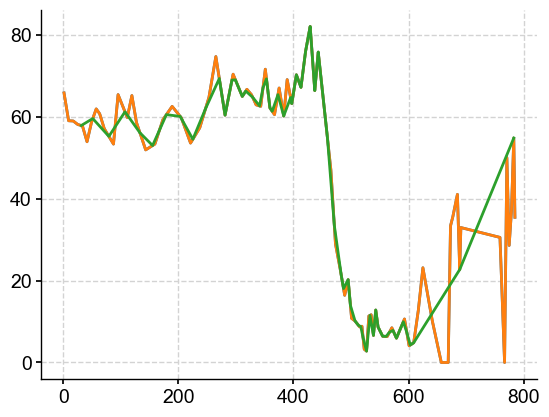

In [49]:
#Include in the d2HC28 conversion to soil water a correction for the changing proportion of Pinus in catchment

# First need to interpolate pine % to the same depths as d2hc28 values
#Create a new DataFrame with 'midpointdepth' values from 0 to 800 in 1 cm intervals
new_midpointdepth = pd.DataFrame({'depth': np.arange(0, 786, 1)})

# Merge the new 'midpointdepth' DataFrame with the existing 'pine' DataFrame
pine_alldepth_df = pd.merge(new_midpointdepth, pine, on='depth', how='left')

# 'merged_df' will have NaNs in columns other than 'midpointdepth' where 'midpointdepth' did not match
# It will retain existing values from 'pine' where 'midpointdepth' values matched

# Interpolate the values in 'pine' dataframe to be at every cm
interpolated_pine = pine_alldepth_df.interpolate(method='index', limit_area='inside')

# Create a new dataframe by aligning 'pine' dataframe with 'c28d2h.midpointdepth'
aligned_pine = interpolated_pine.reindex(c28d2h['depth'])
aligned_pine = aligned_pine.reset_index(drop=True)

# Now 'aligned_pine' contains interpolated values from 'pine' dataframe at 'c28d2h.midpointdepth'
#make plots to double check that the interpolation makes sense
plt.plot(pine.depth,pine.paleoData_values)
plt.plot(interpolated_pine.depth,interpolated_pine.paleoData_values)
plt.plot(aligned_pine.depth,aligned_pine.paleoData_values)

In [92]:
#Convert d2HC22 to mean annual precipitation (lake water) d2H and d2HC28 to soil water d2H using vegetation correction
#Using compiled modern aquatic plant fractionation: Aquatic fractionation for C22 would be -128±4
#Using soils from Hollister et al 2021: terrestrial fractionation for C28 would be -115±15
#Using a compilation of taxon-specific values for vegetation-corrected d2HP
#now calculate the vegetation-corrected d2Hp value
#epsC28pine = -137 #±8 (standard error of the mean) apparent fractionation (wax-precip)
#epsC28herbshrub = -95 #±3  (standard error of the mean) apparent fractionation (wax-precip)
epsC28pine = -167 #±11 (standard error of the mean) biosynthetic fractionation (wax-leaf water)
epsC28herbshrub = -140 #±6 (standard error of the mean) biosynthetic fractionation (wax-leaf water)

epsC28veg = ((aligned_pine.paleoData_values/100)*epsC28pine)+((1-(aligned_pine.paleoData_values/100))*epsC28herbshrub)

epsC22lake = -128 #±5
epsC28P = -115 #±15


# Convert the resulting series to a DataFrame
epsC28veg_df = pd.DataFrame({
    'depth': aligned_pine['depth'],  # Adding depth column
    'epsC28veg': epsC28veg
})
#epsC28veg_df = epsC28veg_df.reset_index(drop=True)

#merge veg correction and C28 dataframes based on depth column
merged_df = pd.merge(c28d2h, epsC28veg_df, on=['depth'])
merged_df2 = pd.merge(merged_df, c22d2h, on=['ageMedian', 'depth'],suffixes=('_c28d2h', '_c22d2h'))
merged_df3 = pd.merge(merged_df2, c22sem, on=['ageMedian', 'depth'],suffixes=('_c22d2h', '_c22SEM'))
C22_C28_d2H = pd.merge(merged_df3, c28sem, on=['ageMedian', 'depth'],suffixes=('_c22SEM', '_c28SEM'))
C22_C28_d2H = C22_C28_d2H.drop_duplicates(subset=['depth'])

# Perform calculations
d2HP_veg = ((C22_C28_d2H['paleoData_values_c28d2h'] + 1000) / ((C22_C28_d2H['epsC28veg'] / 1000) + 1)) - 1000
d2Hlake = ((C22_C28_d2H['paleoData_values_c22d2h'] + 1000) / ((epsC22lake / 1000) + 1)) - 1000
d2HP = ((C22_C28_d2H['paleoData_values_c28d2h'] + 1000) / ((epsC28P / 1000) + 1)) - 1000
eps_lake_P = (((d2HP+1000)/(d2Hlake+1000))-1)*1000
eps_lake_P_veg = (((d2HP_veg+1000)/(d2Hlake+1000))-1)*1000

#calculate uncertainties
#Using lake sediments from Hollister et al 2021: Aquatic fractionation for C22 would be -123, SEM 2‰
#Using soils from Hollister et al 2021: terrestrial fractionation for C28 would be -115, SEM 8‰
#epsC28pine = -137 #SEM 8
#epsC28herbshrub = -95 #SEM 3

#c28sem
#c22sem
meas_unc=2 #total analytical uncertainty is at most 5‰
C22_to_lake_unc=4
C28_to_precip_unc=8
epsC28pine_unc=11
epsC28herbshrub_unc=3 #this includes herb, shrub, and other tree taxa in the catchment today

d2Hlake_unc=(C22_C28_d2H['paleoData_values_c22SEM']**2+C22_to_lake_unc**2)**0.5
d2HP_veg_unc=(C22_C28_d2H['paleoData_values_c28SEM']**2+epsC28pine_unc**2+epsC28herbshrub_unc**2)**0.5
d2HP_unc=(C22_C28_d2H['paleoData_values_c28SEM']**2+C28_to_precip_unc**2)**0.5

eps_lake_P_unc=(d2Hlake_unc**2+d2HP_unc**2)**0.5
eps_lake_P_veg_unc=(d2Hlake_unc**2+d2HP_veg_unc**2)**0.5


# Create a DataFrame for the result
d2Hwater = pd.DataFrame({
    'depth': C22_C28_d2H['depth'],
    'ageMedian': C22_C28_d2H['ageMedian'],
    'd2HP_veg': d2HP_veg, #this is actually leaf water, if use epsBio!
    'd2HP_veg_unc':d2HP_veg_unc, #this is actually leaf water, if use epsBio!
    'd2HP': d2HP,
    'd2HP_unc': d2HP_unc,
    'd2Hlake': d2Hlake,
    'd2Hlake_unc':d2Hlake_unc,
    'eps_lake_P': eps_lake_P,
    'eps_lake_P_unc':eps_lake_P_unc,
    'eps_lake_P_veg': eps_lake_P_veg,
    'eps_lake_P_veg_unc':eps_lake_P_veg_unc
    
})
d2Hwater = d2Hwater.dropna()

In [93]:
d2Hwater.to_csv("Imandra_inferredwater_d2H.csv")
#pd.DataFrame.to_csv('d2Hwater',"Imandra_inferredwater.csv")

In [94]:
#import gdgt results generated in "results" code
GDGT_temps=pd.read_csv("Imandra_GDGT_temps.csv")
GDGT_indices=pd.read_csv("Imandra_GDGT_indices.csv")
brGDGTconc=pd.read_csv("Imandra_brGDGT_concentration.csv")

In [95]:
#merge water and temp datasets on midpoint depths, subtract impact of temp on GDGT
temp_water_merged = pd.merge(GDGT_temps, d2Hwater, on=['depth','ageMedian'])
#convert temp to d2H values, assuming 2.88‰ per °C (Kobashi et al 2018)
temp_water_merged['T_to_iso'] = (temp_water_merged['Zhao MBT'].mean()-temp_water_merged['Zhao MBT'])*2.88
#subtract effect of temp from d2H values
temp_water_merged['iso_no_T'] = temp_water_merged.d2Hlake+temp_water_merged.T_to_iso
#temp_water_merged['iso_no_T']
temp_water_merged

,Unnamed: 0,depth,ageMedian,Russell MBT,Russell SFS,Zhao MBT,Raberg Meth Set,Raberg Full Set,Powers TEX,d2HP_veg,d2HP_veg_unc,d2HP,d2HP_unc,d2Hlake,d2Hlake_unc,eps_lake_P,eps_lake_P_unc,eps_lake_P_veg,eps_lake_P_veg_unc,T_to_iso,iso_no_T
0,0,31,-11.412127,9.222252,10.971393,16.219237,8.847324,7.450711,8.259729,-33.495692,11.842297,-77.853107,8.616264,-77.866972,5.249762,0.015036,10.089599,48.118090,12.953764,2.350431,-75.516542
1,1,51,305.387259,8.694396,10.994972,15.306479,8.230618,7.555623,6.634207,-31.786631,11.897899,-76.723164,8.692526,-75.000000,6.325346,-1.862880,10.750349,46.717156,13.474791,4.979175,-70.020825
2,2,79,993.553336,9.416891,11.673785,16.555802,8.858923,7.946435,8.042307,-31.355746,11.869709,-75.028249,8.653901,-75.000000,5.728001,-0.030539,10.377861,47.182978,13.179530,1.381122,-73.618878
3,3,107,1373.173196,9.128572,11.809209,16.057247,8.403146,8.082632,8.095265,-28.547675,11.926860,-74.124294,8.732125,-75.229358,6.171710,1.194960,10.692988,50.479201,13.429073,2.816961,-72.412396
4,4,133,1831.760492,8.375400,11.788641,14.754877,7.604164,7.928828,8.474783,-26.232022,11.842297,-70.395480,8.616264,-73.623853,5.185557,3.484948,10.056341,51.158303,12.927877,6.567786,-67.056067
5,5,155,2230.555069,8.886766,12.030464,15.639121,8.152862,8.007810,5.078440,-31.810431,11.842297,-74.802260,8.616264,-73.623853,5.185557,-1.272061,10.056341,45.136549,12.927877,4.021164,-69.602689
6,6,179,2683.157138,8.532624,12.010157,15.026745,7.822130,7.918526,5.340059,-28.052177,11.869709,-73.446328,8.653901,-72.133028,5.800000,-1.415397,10.417773,47.507726,13.210980,5.784807,-66.348220
7,7,203,3096.368080,8.802992,12.347074,15.494260,7.979315,8.267030,3.864408,-32.098420,11.842297,-77.175141,8.616264,-74.426606,5.185557,-2.969549,10.056341,45.731852,12.927877,4.438365,-69.988241
8,8,225,3580.871251,9.062482,12.434908,15.942965,8.134604,8.369259,6.115749,-31.101437,11.897899,-74.576271,8.692526,-74.541284,5.586591,-0.037805,10.332957,46.938720,13.144200,3.146093,-71.395191
9,9,247,4202.518334,9.144921,12.685614,16.085518,8.261724,8.458183,6.326574,-29.502576,11.897899,-75.254237,8.692526,-72.247706,5.448853,-3.240661,10.259142,46.073861,13.086252,2.735542,-69.512164


<Figure size 640x480 with 0 Axes>

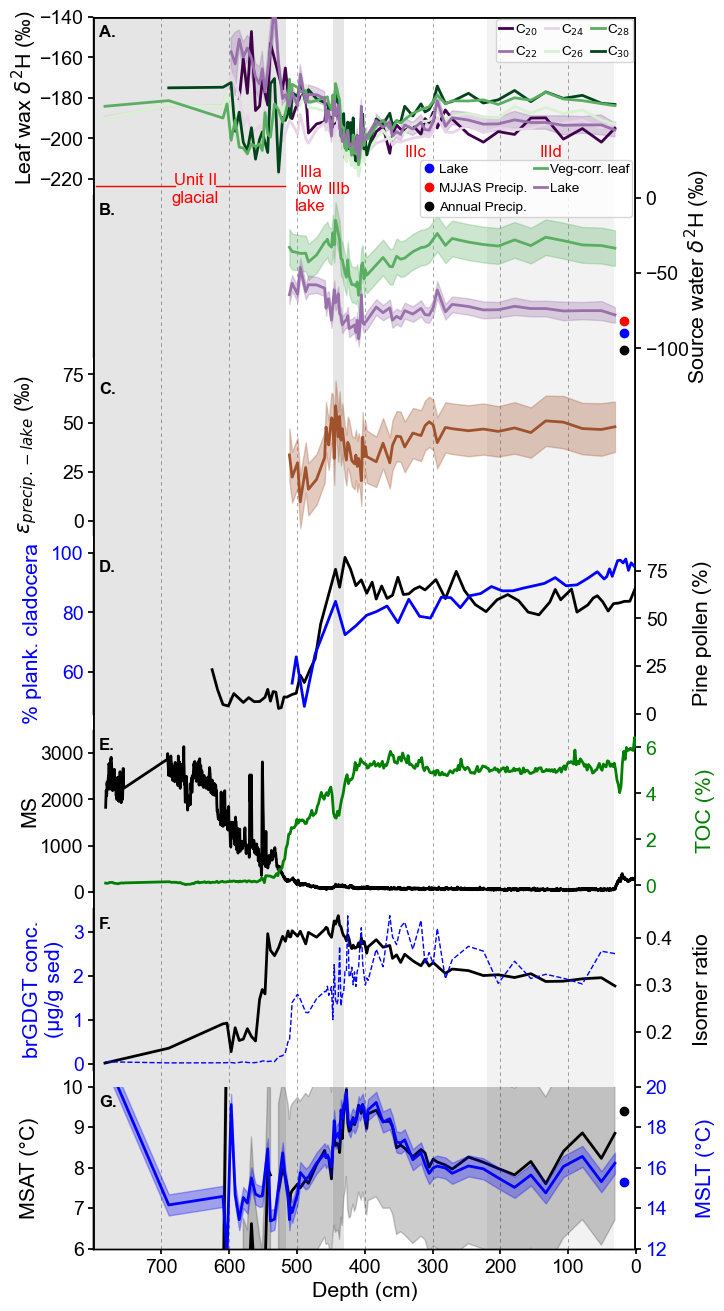

In [160]:
from matplotlib.patches import ConnectionPatch

#assign values for modern observations
mod_lake_d2H=-89.7
mod_MJJAS_P_d2H=-81.8
mod_Ann_P_d2H=-101.0
mod_lake_t_aug=15.3 #Kaverina, I., & Pogozheva, V. (2005)
mod_air_t_MJJAS=9.4 #NOAA GHCN, Monchegorsk station
#Using lake sediments from Hollister et al 2021: Aquatic fractionation for C22 would be -123, SEM 2‰
#Using soils from Hollister et al 2021: terrestrial fractionation for C28 would be -115, SEM 8‰
#epsC28pine = -137 #SEM 8
#epsC28herbshrub = -95 #SEM 3

#c28sem
#c22sem
meas_unc=2 #total analytical uncertainty is at most 5‰
C22_to_lake_unc=2
#C28_to_precip_unc=8
epsC28pine_unc=8
epsC28herbshrub_unc=3

lake_unc=(c22sem['paleoData_values']**2+C22_to_lake_unc**2)**0.5
precip_veg_unc=(c28sem['paleoData_values']**2+epsC28pine_unc**2+epsC28herbshrub_unc**2)**0.5

eps_lake_precip_unc=(lake_unc**2+precip_veg_unc**2)**0.5

plt.figure(1)
fig, axs = plt.subplots(7, 1,sharex=True)

# Assign colors to the # of datasets in your plot
data_sets = [c20d2h, c22d2h_ens, c24d2h, c26d2h, c28d2h_ens, c30d2h]

# Get the number of lines
num_lines = len(data_sets)

# Generate equally spaced colors from 'PRGn' colormap excluding the white color
colors = [cm.PRGn(i / (num_lines - 1)) for i in range(num_lines)]

#remove nans from the data so there won't be gaps in the plot
c20d2h_clean = c20d2h.dropna(subset=['depth', 'paleoData_values'])
c22d2h_clean = c22d2h.dropna(subset=['depth', 'paleoData_values'])
c24d2h_clean = c24d2h.dropna(subset=['depth', 'paleoData_values'])
c30d2h_clean = c30d2h.dropna(subset=['depth', 'paleoData_values'])

#now you can plot!
ax = axs[0]
ax.patch.set_alpha(0)
line1,=ax.plot(c20d2h_clean['depth'], c20d2h_clean['paleoData_values'],c=colors[0],label='C$_{20}$')
line3,=ax.plot(c24d2h_clean['depth'], c24d2h_clean['paleoData_values'],c=colors[2],label='C$_{24}$')
line4,=ax.plot(c26d2h.depth, c26d2h.paleoData_values,c=colors[3],label='C$_{26}$')
line7,=ax.plot(c30d2h_clean.depth, c30d2h_clean.paleoData_values,c=colors[5],label='C$_{30}$')
#c28d2h_ens.common_time().plot_envelope(ax=ax, curve_clr=colors[4],curve_lw=1,shade_clr=colors[4],plot_legend=False)
line2,=ax.plot(c22d2h_clean['depth'], c22d2h_clean['paleoData_values'],c=colors[1],zorder=500,label='C$_{22}$')
ax.fill_between(C22_C28_d2H['depth'], C22_C28_d2H['paleoData_values_c22d2h']-C22_C28_d2H['paleoData_values_c22SEM'], C22_C28_d2H['paleoData_values_c22d2h']+C22_C28_d2H['paleoData_values_c22SEM'],
    alpha=0.3, edgecolor=colors[1], facecolor=colors[1])
line6,=ax.plot(c28d2h.depth, c28d2h.paleoData_values,c=colors[4],label='C$_{28}$')
ax.set_xlim(800,0)
ax.set_ylim(-220,-140)
ax.set_xlabel(None)
ax.set_ylabel('Leaf wax $\delta^{2}$H (‰)')
ax.grid(visible=False)
ax.legend(handles=[line1,line2,line3,line4,line6,line7],
          loc='upper right', fontsize='x-small',ncols=3,frameon=True,
          columnspacing=0.5,borderpad=0.2,borderaxespad=0.2,handletextpad=0.2, handlelength=1)


ax = axs[1]
ax.patch.set_alpha(0)
#ax.plot(d2Hwater.depth,d2Hwater.d2HP,c=colors[4],linestyle='--',lw=1,label='Precip.')
ax.plot(17, mod_lake_d2H, 'bo', label='Lake',zorder=5)  # use this to plot a single point
ax.plot(17, mod_MJJAS_P_d2H, 'ro', label='MJJAS Precip.',zorder=5)  # use this to plot a single point
ax.plot(17, mod_Ann_P_d2H, 'ko', label='Annual Precip.',zorder=5)  # use this to plot a single point
ax.plot(d2Hwater.depth,d2Hwater.d2HP_veg,c=colors[4],label='Veg-corr. leaf')
ax.fill_between(d2Hwater.depth, d2Hwater.d2HP_veg-d2Hwater.d2HP_veg_unc, d2Hwater.d2HP_veg+d2Hwater.d2HP_veg_unc,
    alpha=0.3, edgecolor=colors[4], facecolor=colors[4])
ax.plot(d2Hwater['depth'],d2Hwater['d2Hlake'],c=colors[1],label='Lake')
ax.fill_between(d2Hwater['depth'], d2Hwater['d2Hlake']-d2Hwater['d2Hlake_unc'], d2Hwater['d2Hlake']+d2Hwater['d2Hlake_unc'],
    alpha=0.3, edgecolor=colors[1], facecolor=colors[1])
ax.set_xlim(800,0)
ax.set_xlabel(None)
ax.set_ylabel('Source water $\delta^{2}$H (‰)')
ax.set_xticks([])
ax.grid(visible=False)
ax.legend(loc='lower right',bbox_to_anchor=(0.998, 0.85), fontsize='x-small',ncols=2,frameon=True,
          columnspacing=0.5,borderpad=0.2,borderaxespad=0.2,handletextpad=0.2, handlelength=1)

ax = axs[2]
ax.patch.set_alpha(0)
#ensemble_eps.common_time().slice([-200, 11300]).plot_envelope(ax=ax, figsize=(16,10),curve_clr='#D1B26F',curve_lw=1, shade_clr='#D1B26F',plot_legend=False)
#line1,=ax.plot(eps['depth'][0:63], eps['paleoData_values'][0:63],c='#D1B26F',label='C$_{28}$-C$_{22}$')
#line2,=ax.plot(d2Hwater['depth'][0:60],d2Hwater['eps_lake_P'][0:60],c='sienna',linestyle='--',lw=1,label='Precip.-Lake')
line3,=ax.plot(d2Hwater['depth'],d2Hwater['eps_lake_P_veg'],c='sienna',label='Veg-corr. leaf-Lake', zorder=1000)
ax.fill_between(d2Hwater['depth'], d2Hwater['eps_lake_P_veg']-d2Hwater['eps_lake_P_veg_unc'], d2Hwater['eps_lake_P_veg']+d2Hwater['eps_lake_P_veg_unc'],
    alpha=0.3, edgecolor='sienna', facecolor='sienna')
ax.set_xlim(800,0)
#ax.set_ylim(-25,70)
ax.set_xlabel(None)
ax.set_ylabel('$\epsilon_{precip.-lake}$ (‰)')
ax.grid(visible=False)
#ax.axhline(0,11000,-100,color='k', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)
#ax.legend(handles=[line1,line2,line3],
 #         loc='lower right',bbox_to_anchor=(0.998, .95), fontsize='x-small',ncols=3,frameon=True,
  #        columnspacing=0.5,borderpad=0.2,borderaxespad=0.2,handletextpad=0.2, handlelength=1)

ax = axs[3]
ax.patch.set_alpha(0)
ax.plot(pine.depth[0:72], pine.paleoData_values[0:72],c='k')
#pine_ens.common_time().plot_envelope(ax=ax, curve_clr='k',curve_lw=1, shade_clr='k')
ax.set_xlim(800,0)
ax.set_ylim(0,85)
#ax.get_legend().remove()
ax.grid(visible=False)
ax.set_ylabel('Pine pollen (%)')
ax.set_xlabel(None)

ax3t=axs[3].twinx()
ax = ax3t
ax.patch.set_alpha(0)
ax.plot(cladocera.depth, cladocera.paleoData_values,c='b')
ax.set_xlim(800,0)
#ax.set_ylim(60,-5)
ax.grid(visible=False)
ax.tick_params(axis='y', labelcolor='b')
ax.spines['bottom'].set_visible(False)
ax.yaxis.tick_left()
ax.yaxis.set_label_coords(-.13, 0.5)
ax.set_ylabel('% plank. cladocera',c='b')
ax.set_xlabel(None)


ax = axs[4]
ax.patch.set_alpha(0)
ax.plot(MS.depth, MS.paleoData_values,c='k')
#MS_ens.common_time().plot_envelope(ax=ax, curve_clr='k',curve_lw=1, shade_clr='k')
ax.set_xlim(800,0)
ax.set_ylim(0,3500)
#ax.get_legend().remove()
ax.grid(visible=False)
ax.set_ylabel('MS')
ax.set_xlabel(None)

ax4t=axs[4].twinx()
ax = ax4t
ax.patch.set_alpha(0)
ax.plot(TOC.depth, TOC.paleoData_values,c='g')
#TOC_ens.common_time().plot_envelope(ax=ax4t, curve_clr='g',curve_lw=1, shade_clr='g')
ax.set_xlim(800,0)
#ax.set_ylim(6,10)
#ax.get_legend().remove()
ax.grid(visible=False)
ax.tick_params(axis='y', labelcolor='g')
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_coords(1.11, 0.5)
ax.set_ylabel('TOC (%)',c='g')
ax.set_xlabel(None)

ax = axs[5]
ax.patch.set_alpha(0)
ax.plot(GDGT_indices.depth, GDGT_indices['IR'],c='k')
#ax.plot(GDGT_temps.depth, GDGT_temps['Raberg Methyl Set'],c='k')
ax.set_xlim(800,0)
#ax.set_ylim(8,18)
ax.grid(visible=False)
ax.set_ylabel('Isomer ratio')
ax.set_xlabel(None)

ax5t=axs[5].twinx()
ax = ax5t
ax.patch.set_alpha(0)
ax.plot(brGDGTconc.depth, brGDGTconc.paleoData_values/1000,c='b',lw=1,linestyle='--')
ax.set_xlim(800,0)
#ax.set_ylim(6,10)
ax.grid(visible=False)
ax.tick_params(axis='y', labelcolor='b')
ax.spines['bottom'].set_visible(False)
ax.yaxis.tick_left()
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.set_ylabel('brGDGT conc.\n(µg/g sed)',c='b')
ax.set_xlabel(None)

ax = axs[6]
ax.patch.set_alpha(0)
ax.plot(GDGT_temps['depth'], GDGT_temps['Raberg Meth Set'],c='k')
ax.fill_between(GDGT_temps['depth'], GDGT_temps['Raberg Meth Set']-2.14, GDGT_temps['Raberg Meth Set']+2.14,
    alpha=0.2, edgecolor='k', facecolor='k')
ax.plot(17, mod_air_t_MJJAS, 'ko', label='MJJAS Air')  # use this to plot a single point
#ax.axhline(GDGT_temps['Raberg Methyl Set'][0],11000,-100,color='k', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)
ax.set_xlim(800,0)
ax.set_ylim(6,10)
ax.grid(visible=False)
ax.set_ylabel('MSAT (°C)')

ax6t=axs[6].twinx()
ax = ax6t
ax.patch.set_alpha(0)
ax.plot(GDGT_temps['depth'], GDGT_temps['Zhao MBT'],c='b')
ax.fill_between(GDGT_temps['depth'], GDGT_temps['Zhao MBT']-.52, GDGT_temps['Zhao MBT']+.52,
    alpha=0.3, edgecolor='b', facecolor='b')
ax.plot(17, mod_lake_t_aug, 'bo', label='Aug. Lake')  # use this to plot a single point
#ax.axhline(GDGT_temps['Zhao MBT'][0],11000,-100,color='b', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)
ax.yaxis.set_label_coords(1.11, 0.5)
ax.tick_params(axis='y', labelcolor='b')
ax.set_xlim(800,0)
ax.set_ylim(12,20)
ax.grid(visible=False)
ax.set_ylabel('MSLT (°C)',c='b')

xticks = np.arange(0, 800, 100)

# Assuming axs is a 2D array containing your subplots
for i, ax in enumerate(axs):
    # Calculate the position for the label in each subplot
    x_pos = 0.01  # Adjust the x-coordinate as needed
    y_pos = 0.95   # Adjust the y-coordinate as needed

    # Add the label to the upper left corner of each subplot
    ax.text(x_pos, y_pos, f"{chr(65 + i)}.", transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

    # Add minor grid lines at every 1000 years on the x-axis
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))  # Set minor ticks at every 1000 years

    # Add x-axis label and ticks only to the bottom subplot
    if i == len(axs) - 1:
        ax.set_xlabel('Depth (cm)')
        ax.set_xticks(xticks)

    else:
        ax.xaxis.set_ticks_position('none')

    # Remove x-axis ticks and lines for all subplots except the bottom one
    if i < len(axs) - 1:
        ax.spines['bottom'].set_visible(False)

    # Alternate y-axis ticks and labels left-right-left-right
    if i % 2 == 0:
        ax.yaxis.tick_left()
        ax.yaxis.set_label_coords(-0.1, 0.5)
    else:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_coords(1.14, 0.5)

ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(800,0)

#draw a rectangle to highlight specific time span in the plot
ax_full.axvspan(800,516,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.2) #add this in to draw a single rectangle
ax_full.axvspan(447,431,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.2) #add this in to draw a single rectangle
ax_full.axvspan(32,220,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.1)

# These lines highlight the span of a specific lithological unit
ax_full.axhline(.863, xmin=0.005, xmax=.15,color='red',linewidth=1,zorder=10)
ax_full.axhline(.863, xmin=0.225, xmax=.354,color='red',linewidth=1,zorder=10)
#add labels to each lithological unit
ax_full.text(650, .86, 'Unit II\nglacial', fontsize=12, color='red', ha='center', va='center')
ax_full.text(480, .86, 'IIIa\nlow\nlake', fontsize=12, color='red', ha='center', va='center')
ax_full.text(438, .86, 'IIIb', fontsize=12, color='red', ha='center', va='center')
ax_full.text(325, .89, 'IIIc', fontsize=12, color='red', ha='center', va='center')
ax_full.text(125, .89, 'IIId', fontsize=12, color='red', ha='center', va='center')


#draw vertical dashed lines every 1kyr
for year in range(0, 800, 100):
    ax_full.axvline(year, 0, 1, color='k', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)

#draw black lines around the plot
ax_full.axvline(800,0,1,color='k',zorder=1)
ax_full.axvline(2,0,1,color='k',zorder=1)
ax_full.axhline(1,800,0,color='k',zorder=1)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.1)

#fig.set_size_inches(14, 20)
fig.set_size_inches(7, 16)
plt.show()


In [155]:
#EKT notes to self: now update figs for main text!

<Figure size 640x480 with 0 Axes>

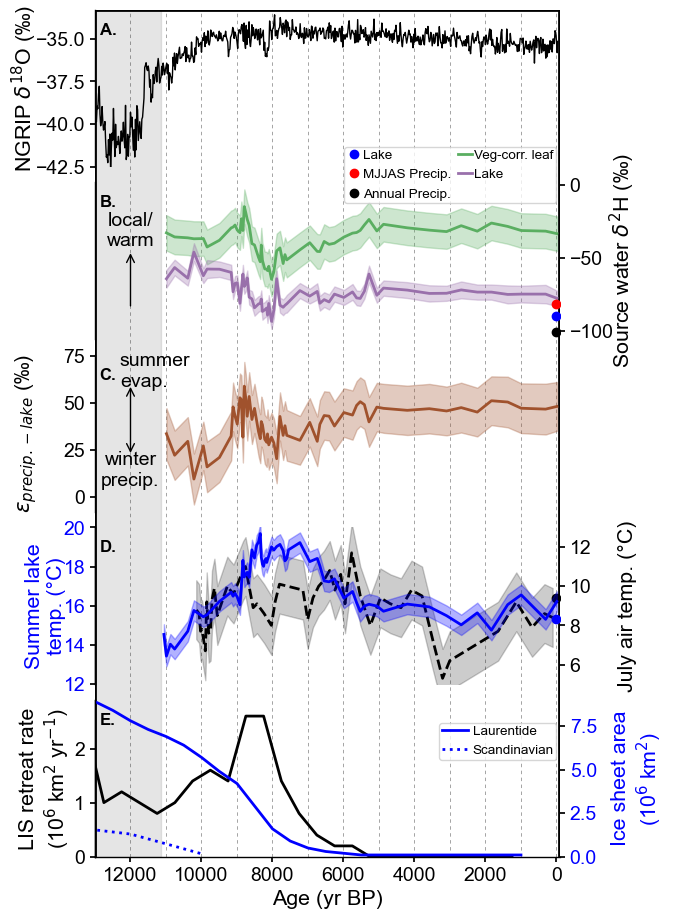

In [146]:
from matplotlib.patches import ConnectionPatch

mod_lake_d2H=-89.7
mod_MJJAS_P_d2H=-81.8
mod_Ann_P_d2H=-101.0
mod_lake_t_aug=15.3 #Kaverina, I., & Pogozheva, V. (2005)
mod_air_t_MJJAS=9.4 #NOAA GHCN, Monchegorsk station
#Using lake sediments from Hollister et al 2021: Aquatic fractionation for C22 would be -123, SEM 2‰
#Using soils from Hollister et al 2021: terrestrial fractionation for C28 would be -115, SEM 8‰
#epsC28pine = -137 #SEM 8
#epsC28herbshrub = -95 #SEM 3

#c28sem
#c22sem
meas_unc=2 #total analytical uncertainty is at most 5‰
C22_to_lake_unc=2
#C28_to_precip_unc=8
epsC28pine_unc=8
epsC28herbshrub_unc=3

lake_unc=(c22sem['paleoData_values']**2+C22_to_lake_unc**2)**0.5
precip_veg_unc=(c28sem['paleoData_values']**2+epsC28pine_unc**2+epsC28herbshrub_unc**2)**0.5

eps_lake_precip_unc=(lake_unc**2+precip_veg_unc**2)**0.5

plt.figure(1)
fig, axs = plt.subplots(5, 1,sharex=True)

# Example data (replace with your actual data)
data_sets = [c20d2h, c22d2h_ens, c24d2h, c26d2h, c28d2h_ens, c30d2h]

# Get the number of lines
num_lines = len(data_sets)

# Generate equally spaced colors from 'PRGn' colormap excluding the white color
colors = [cm.PRGn(i / (num_lines - 1)) for i in range(num_lines)]

ax = axs[0]
ax.patch.set_alpha(0)
ax.plot(NGRIPd18O['ageMedian'], NGRIPd18O['paleoData_values'],c='k',linewidth=1)
ax.set_xlim(13000,-100)
ax.set_ylim(-42.5,-33.3)
ax.set_xlabel(None)
ax.set_ylabel('NGRIP $\delta^{18}$O (‰)')
ax.grid(visible=False)

ax = axs[1]
ax.patch.set_alpha(0)
ax.plot(0, mod_lake_d2H, 'bo', label='Lake',zorder=5)  # use this to plot a single point
ax.plot(0, mod_MJJAS_P_d2H, 'ro', label='MJJAS Precip.',zorder=5)  # use this to plot a single point
ax.plot(0, mod_Ann_P_d2H, 'ko', label='Annual Precip.',zorder=5)  # use this to plot a single point
ax.plot(d2Hwater.ageMedian,d2Hwater.d2HP_veg,c=colors[4],label='Veg-corr. leaf')
ax.fill_between(d2Hwater.ageMedian, d2Hwater.d2HP_veg-d2Hwater.d2HP_veg_unc, d2Hwater.d2HP_veg+d2Hwater.d2HP_veg_unc,
    alpha=0.3, edgecolor=colors[4], facecolor=colors[4])
ax.plot(d2Hwater['ageMedian'][0:60],d2Hwater['d2Hlake'][0:60],c=colors[1],label='Lake')
ax.fill_between(d2Hwater['ageMedian'][0:60], d2Hwater['d2Hlake'][0:60]-d2Hwater['d2Hlake_unc'][0:60], d2Hwater['d2Hlake'][0:60]+d2Hwater['d2Hlake_unc'][0:60],
    alpha=0.3, edgecolor=colors[1], facecolor=colors[1])
ax.set_xlim(13000,-100)
ax.set_xlabel(None)
ax.set_ylabel('Source water $\delta^{2}$H (‰)')
ax.set_xticks([])
ax.grid(visible=False)
# Define the x and y position for the arrow
x_pos = 12000
y_pos = -45

# Draw an arrow pointing vertically upward
ax.annotate('', xy=(x_pos, y_pos), xytext=(x_pos, y_pos - 40),arrowprops=dict(facecolor=colors[1], arrowstyle='->'))

# Add a label to the arrow
ax.text(x_pos, y_pos + 3, 'local/\nwarm', ha='center')

ax.legend(loc='lower right',bbox_to_anchor=(0.998, 0.85), fontsize='x-small',ncols=2,frameon=True,
          columnspacing=0.5,borderpad=0.2,borderaxespad=0.2,handletextpad=0.2, handlelength=1)

ax = axs[2]
ax.patch.set_alpha(0)
line3,=ax.plot(d2Hwater['ageMedian'],d2Hwater['eps_lake_P_veg'],c='sienna',label='Veg-corr. leaf-Lake', zorder=1000)
ax.fill_between(d2Hwater['ageMedian'], d2Hwater['eps_lake_P_veg']-d2Hwater['eps_lake_P_veg_unc'], d2Hwater['eps_lake_P_veg']+d2Hwater['eps_lake_P_veg_unc'],
    alpha=0.3, edgecolor='sienna', facecolor='sienna')
ax.set_xlim(13000,-100)
#ax.set_ylim(-25,70)
ax.set_xlabel(None)
ax.set_ylabel('$\epsilon_{precip.-lake}$ (‰)')
ax.grid(visible=False)
# Define the x and y position for the arrow
x_pos = 12000
y_pos = 60

# Draw an arrow pointing vertically upward
ax.annotate('', xy=(x_pos, y_pos), xytext=(x_pos, y_pos - 38),arrowprops=dict(facecolor=colors[1], arrowstyle='<->'))

# Add a label to the arrow
ax.text(x_pos+300, y_pos + 17, 'summer\nevap.', ha='left', va='top')
# Add a label to the arrow
ax.text(x_pos, y_pos - 56, 'winter\nprecip.', ha='center', va='bottom')


ax = axs[3]
ax.patch.set_alpha(0)
#ax.plot(GDGT_temps['ageMedian'][0:65], GDGT_temps['Raberg Methyl Set'][0:65],c='k')
#ax.fill_between(GDGT_temps['ageMedian'][0:65], GDGT_temps['Raberg Methyl Set'][0:65]-2.14, GDGT_temps['Raberg Methyl Set'][0:65]+2.14,
 #   alpha=0.2, edgecolor='k', facecolor='k')
ax.plot(Kup['Age'], Kup['Temp'],c='k',linestyle='--',label="Kupal'noe")
ax.fill_between(Kup['Age'], Kup['Temp']-1.5, Kup['Temp']+1.5,
    alpha=0.2, edgecolor='k', facecolor='k')
ax.plot(0, mod_air_t_MJJAS, 'ko', label='MJJAS Air')  # use this to plot a single point
#ax.axhline(GDGT_temps['Raberg Methyl Set'][0],13000,-100,color='k', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)
ax.set_xlim(13000,-100)
ax.set_ylim(5,13)
ax.grid(visible=False)
ax.set_ylabel('July air temp. (°C)')

ax3t=axs[3].twinx()
ax = ax3t
ax.patch.set_alpha(0)
ax.plot(GDGT_temps['ageMedian'], GDGT_temps['Zhao MBT'],c='b',label='Imandra')
ax.fill_between(GDGT_temps['ageMedian'], GDGT_temps['Zhao MBT']-.52, GDGT_temps['Zhao MBT']+.52,
    alpha=0.3, edgecolor='b', facecolor='b')
ax.plot(0, mod_lake_t_aug, 'bo', label='Aug. Lake')  # use this to plot a single point
#ax.axhline(GDGT_temps['Zhao MBT'][0],13000,-100,color='b', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)
ax.yaxis.tick_left()
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', labelcolor='b')
ax.set_xlim(13000,-100)
ax.set_ylim(12,20)
ax.grid(visible=False)
ax.set_ylabel('Summer lake\ntemp. (°C)',c='b')

ax = axs[4]
ax.patch.set_alpha(0)
ax.plot(LIS['midpoint age for 1st derivative'], LIS['1st derivative of areal extent, 10^6 km^2/yr'],c='k')
#ax.plot(GDGT_temps.ageMedian, GDGT_temps['Raberg Methyl Set'],c='k')
ax.set_xlim(13000,-100)
ax.set_ylim(0,2.9)
ax.grid(visible=False)
ax.set_ylabel('LIS retreat rate\n(10$^{6}$ km$^{2}$ yr$^{-1}$)')
ax.set_xlabel('Age (Year BP)')

ax4t=axs[4].twinx()
ax = ax4t
ax.patch.set_alpha(0)
ax.plot(LIS['Age'], LIS['Areal extent, 10^6 km^2'],c='b',label="Laurentide")
ax.plot(EIS['Age'], EIS['EIS_Size'],c='b',linestyle=':',label="Scandinavian")
ax.set_xlim(13000,-100)
ax.set_ylim(0,9)
ax.grid(visible=False)
ax.tick_params(axis='y', labelcolor='b')
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_coords(1.11, 0.5)
ax.set_ylabel('Ice sheet area\n(10$^{6}$ km$^{2}$)',c='b')
ax.set_xlabel(None)
ax.legend(loc='lower right',bbox_to_anchor=(0.998, 0.6), fontsize='x-small',ncols=1,frameon=True,
          columnspacing=0.5,borderpad=0.2,borderaxespad=0.2,handletextpad=0.3, handlelength=2)


xticks = np.arange(0, 13000, 2000)

# Assuming axs is a 2D array containing your subplots
for i, ax in enumerate(axs):
    # Calculate the position for the label in each subplot
    x_pos = 0.01  # Adjust the x-coordinate as needed
    y_pos = 0.92   # Adjust the y-coordinate as needed

    # Add the label to the upper left corner of each subplot
    ax.text(x_pos, y_pos, f"{chr(65 + i)}.", transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

    # Add minor grid lines at every 1000 years on the x-axis
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1000))  # Set minor ticks at every 1000 years

    # Add x-axis label and ticks only to the bottom subplot
    if i == len(axs) - 1:
        ax.set_xlabel('Age (yr BP)')
        ax.set_xticks(xticks)

    else:
        ax.xaxis.set_ticks_position('none')

    # Remove x-axis ticks and lines for all subplots except the bottom one
    if i < len(axs) - 1:
        ax.spines['bottom'].set_visible(False)

    # Alternate y-axis ticks and labels left-right-left-right
    if i % 2 == 0:
        ax.yaxis.tick_left()
        ax.yaxis.set_label_coords(-0.12, 0.5)
    else:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_coords(1.165, 0.5)

axs[4].yaxis.set_label_coords(-0.05, 0.5)

ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(13000,-100)

#draw a rectangle to highlight specific time span in the plot
ax_full.axvspan(13000,11140,color='gray',zorder=-1,alpha=0.2) #add this in to draw a single rectangle

#draw vertical dashed lines every 1kyr
for year in range(0, 13000, 1000):
    ax_full.axvline(year, 0, 1, color='k', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)

#draw black lines around the plot
ax_full.axvline(13000,0,1,color='k',zorder=1)
ax_full.axvline(-80,0,1,color='k',zorder=1)
ax_full.axhline(1,13000,-100,color='k',zorder=1)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.1)

#fig.set_size_inches(14, 20)
fig.set_size_inches(6, 11)

fig.savefig("ImandraInterps.pdf", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

plt.show()


In [113]:
## Use 'getlipd()' to import age ensemble data for a single paleoData variable

# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
spaime_18O_ens, spaime_18O = getlipd('ScandIsotopes/spaime.Hammarlund.2004.lpd',
                                           paleoData_variableName='d18O',
                                           depth_name='depth',
                                           ageMedian_name='age',
                                           val_unit='‰')

# Check first several rows of the returned 'age_axis' dataframe
print(spaime_18O.head())

# Show that unique depth columns were imported from each paleoData table correctly
print(np.shape(spaime_18O.depth))

# KRL Notes:
# LiPD file must already have an age model and age ensemble mapped to it, which currently can only be done using
# GeoChronR interfacing with Bacon

# Loading times depend on LiPD file size. From experience, importing any LiPD variable from a file with a 4000-row
# ITRAX paleoData table makes 'getlipd()' take ~1.5 minutes per variable... gross

# 'ens_num=0' was used for both instances of 'getlipd()' but with different depth names resulted in correctly
# importing both depth columns. It seems like the function to import LiPD files in Python don't maintain the stricter
# indexing of multiple paleoData tables like GeoChronR does



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Loaded..
              datasetName                                      ensembleTable  \
0  Spaime.Hammarlund.2004  http://linked.earth/lipd/Spaime.Hammarlund.200...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-9.116, 100.89, -6.266, 60.055, 17.279, -35....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [338.0, 343.01, 348.02, 353.02, 358.03, 363.04...                 cm  None  
Extracting timeseries from dataset: Spaime.Hammarlund.2004 ...
   depth  ageMedian  paleoData_values
0  340.9     46.620           -19.996
1  347.7    164.625           -22.065
2  360.3    391.565           -21.272
3  366.6    510.139           -20.740
4  372.8    630.583           -18.776
(41,)


In [114]:
## Use 'getlipd()' to import age ensemble data for a single paleoData variable

# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
tibetanus_18O_ens, tibetanus_18O = getlipd('ScandIsotopes/tibetanus.Hammarlund.2002.lpd',
                                           paleoData_variableName='d18O',
                                           depth_name='depth',
                                           ageMedian_name='age',
                                           val_unit='‰')

# Check first several rows of the returned 'age_axis' dataframe
print(tibetanus_18O.head())

# Show that unique depth columns were imported from each paleoData table correctly
print(np.shape(tibetanus_18O.depth))

# KRL Notes:
# LiPD file must already have an age model and age ensemble mapped to it, which currently can only be done using
# GeoChronR interfacing with Bacon

# Loading times depend on LiPD file size. From experience, importing any LiPD variable from a file with a 4000-row
# ITRAX paleoData table makes 'getlipd()' take ~1.5 minutes per variable... gross

# 'ens_num=0' was used for both instances of 'getlipd()' but with different depth names resulted in correctly
# importing both depth columns. It seems like the function to import LiPD files in Python don't maintain the stricter
# indexing of multiple paleoData tables like GeoChronR does



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


Loaded..
                 datasetName  \
0  Tibetanus.Hammarlund.2002   

                                       ensembleTable ensembleVariableName  \
0  http://linked.earth/lipd/Tibetanus.Hammarlund....          ageEnsemble   

                              ensembleVariableValues ensembleVariableUnits  \
0  [[16.228, 113.07, 55.708, 146.52, 85.552, 84.6...                 yr BP   

  ensembleDepthName                                ensembleDepthValues  \
0             depth  [0.0, 5.073, 10.145, 15.218, 20.291, 25.364, 3...   

  ensembleDepthUnits notes  
0                 cm  None  
Extracting timeseries from dataset: Tibetanus.Hammarlund.2002 ...
   depth  ageMedian  paleoData_values
0     65        0.0            -13.03
1    112      129.6            -12.97
2    150      226.3            -12.97
3    200      306.3            -13.43
4    252      414.0            -13.16
(60,)


In [141]:
tibetanus_18O_ens

/Users/elizabeth/anaconda3/envs/pyleo/lib/python3.10/site-packages/pyleoclim/core/multipleseries.py:2231: UserWarning: Time unit "ageEnsemble yr BP" unknown; triggering defaults
  df = pd.DataFrame({ser.metadata['label']: ser.to_pandas(paleo_style=paleo_style) for ser in ms.series_list})


                       None
datetime                   
1745-08-11 02:38:30 -13.030
3237-12-10 08:33:33 -12.970
4466-05-24 14:42:04 -12.970
6554-01-27 23:30:02 -13.430
8697-09-24 10:50:47 -13.160
9736-04-16 14:52:46 -12.720
9736-04-16 14:52:46 -13.060
9736-04-16 14:52:46 -13.920
9736-04-16 14:52:46 -13.280
9736-04-16 14:52:46 -13.110
9736-04-16 14:52:46 -13.240
9736-04-16 14:52:46 -13.030
9736-04-16 14:52:46 -13.530
9736-04-16 14:52:46 -13.340
9736-04-16 14:52:46 -13.420
9736-04-16 14:52:46 -12.900
9736-04-16 14:52:46 -12.960
9736-04-16 14:52:46 -13.070
9736-04-16 14:52:46 -13.300
9736-04-16 14:52:46 -13.100
9736-04-16 14:52:46 -12.690
9736-04-16 14:52:46 -12.770
9736-04-16 14:52:46 -12.770
9736-04-16 14:52:46 -12.360
9736-04-16 14:52:46 -12.170
9736-04-16 14:52:46 -11.950
9736-04-16 14:52:46 -11.565
9736-04-16 14:52:46 -11.400
9736-04-16 14:52:46 -11.290
9736-04-16 14:52:46 -13.070
9736-04-16 14:52:46 -13.260
9736-04-16 14:52:46 -13.470
9736-04-16 14:52:46 -13.690
9736-04-16 14:52:46 

In [137]:
## Use 'getlipd()' to import age ensemble data for a single paleoData variable

# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
chuna_18O_ens, chuna_18O = getlipd('ScandIsotopes/chuna.Jones.2005.lpd',
                                           paleoData_variableName='d18O',
                                           depth_name='depth',
                                           ageMedian_name='age',
                                           val_unit='‰')

# Check first several rows of the returned 'age_axis' dataframe
print(chuna_18O.head())

# Show that unique depth columns were imported from each paleoData table correctly
print(np.shape(chuna_18O.depth))

# KRL Notes:
# LiPD file must already have an age model and age ensemble mapped to it, which currently can only be done using
# GeoChronR interfacing with Bacon

# Loading times depend on LiPD file size. From experience, importing any LiPD variable from a file with a 4000-row
# ITRAX paleoData table makes 'getlipd()' take ~1.5 minutes per variable... gross

# 'ens_num=0' was used for both instances of 'getlipd()' but with different depth names resulted in correctly
# importing both depth columns. It seems like the function to import LiPD files in Python don't maintain the stricter
# indexing of multiple paleoData tables like GeoChronR does



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Loaded..
        datasetName                                      ensembleTable  \
0  Chuna.Jones.2005  http://linked.earth/lipd/Chuna.Jones.2005.chro...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[11.141, 7.281, 8.403, 6.931, 5.421, 8.136, 4...   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.031, 10.062, 15.094, 20.125, 25.156, 3...                 cm  None  
Extracting timeseries from dataset: Chuna.Jones.2005 ...
   depth  ageMedian  paleoData_values
0   1.25      9.500              21.0
1   6.00    140.000              22.7
2  11.00    322.326              23.0
3  15.00    444.052              23.7
4  16.00    474.453              23.0
(149,)


In [138]:
chuna_18O_ens

/Users/elizabeth/anaconda3/envs/pyleo/lib/python3.10/site-packages/pyleoclim/core/multipleseries.py:2231: UserWarning: Time unit "ageEnsemble yr BP" unknown; triggering defaults
  df = pd.DataFrame({ser.metadata['label']: ser.to_pandas(paleo_style=paleo_style) for ser in ms.series_list})


                     None
datetime                 
112-02-29 06:23:35   21.0
464-04-07 18:11:51   22.7
671-04-24 14:57:14   23.0
722-04-13 22:37:09   23.7
734-09-13 03:38:18   23.0
...                   ...
9085-02-02 21:36:11  24.3
9085-02-02 21:36:11  24.0
9085-02-02 21:36:11  24.2
9085-02-02 21:36:11  23.7
9085-02-02 21:36:11  24.0

[149 rows x 1 columns]

In [118]:
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
#this one doesn't work...a problem with tuples
#a more manual extraction of the data, which works, but without the age ensemble, below
soylegrotta_18O_ens, soylegrotta_18O = getlipd('ScandIsotopes/Soylegrottacave.Linge.2001.lpd',
                                           paleoData_variableName='d18O',
                                           depth_name='depth',
                                           ageMedian_name='age',
                                           val_unit='‰')

# Check first several rows of the returned 'age_axis' dataframe
print(soylegrotta_18O.head())

# Show that unique depth columns were imported from each paleoData table correctly
print(np.shape(soylegrotta_18O.depth))

# KRL Notes:
# LiPD file must already have an age model and age ensemble mapped to it, which currently can only be done using
# GeoChronR interfacing with Bacon

# Loading times depend on LiPD file size. From experience, importing any LiPD variable from a file with a 4000-row
# ITRAX paleoData table makes 'getlipd()' take ~1.5 minutes per variable... gross

# 'ens_num=0' was used for both instances of 'getlipd()' but with different depth names resulted in correctly
# importing both depth columns. It seems like the function to import LiPD files in Python don't maintain the stricter
# indexing of multiple paleoData tables like GeoChronR does



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.41it/s]

Loaded..
Empty DataFrame
Columns: [datasetName, ensembleTable, ensembleVariableName, ensembleVariableValues, ensembleVariableUnits, ensembleDepthName, ensembleDepthValues, ensembleDepthUnits, notes]
Index: []


Extracting timeseries from dataset: Soylegrottacave.Linge.2001 ...


TypeError: Field elements must be 2- or 3-tuples, got '167.5'

In [119]:
#Create a path to the data
filename = 'ScandIsotopes/Soylegrottacave.Linge.2001.lpd'

#Initialize the lipd object
D = LiPD()

#Load the data
D.load(filename)

Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]

Loaded..


In [125]:
#Pull the paleo data into a list. We use all the available data set names because our file only contains one dataset
timeseries,df = D.get_timeseries(D.get_all_dataset_names(),to_dataframe=True)
print(df)

Extracting timeseries from dataset: Soylegrottacave.Linge.2001 ...
         mode time_id                 dataSetName agesPerKyr  \
0   paleoData     age  Soylegrottacave.Linge.2001         NA   
1   paleoData     age  Soylegrottacave.Linge.2001         NA   
2   paleoData     age  Soylegrottacave.Linge.2001         NA   
3   paleoData     age  Soylegrottacave.Linge.2001         NA   
4   paleoData     age  Soylegrottacave.Linge.2001         NA   
..        ...     ...                         ...        ...   
81  paleoData     age  Soylegrottacave.Linge.2001         NA   
82  paleoData     age  Soylegrottacave.Linge.2001         NA   
83  paleoData     age  Soylegrottacave.Linge.2001         NA   
84  paleoData     age  Soylegrottacave.Linge.2001         NA   
85  paleoData     age  Soylegrottacave.Linge.2001         NA   

                                        lipdverseLink  \
0   http://lipdverse.org/SISAL-LiPD/2_0_1/Soylegro...   
1   http://lipdverse.org/SISAL-LiPD/2_0_1/Soylegro

In [126]:
#Identify the variable of interest.
#print(df['paleoData_variableName'])
df['paleoData_variableName'].unique()

array(['ageBchronUncertaintyLow', 'd18OPrecision', 'ageBchron.age',
       'ageStalAgeUncertaintyLow', 'd13CPrecision', 'd13C',
       'd18OStandard', 'ageUncertaintyLow', 'agecopRaUncertaintyHigh',
       'agecopRa.age', 'agelinInterp.age', 'd13CStandard', 'mineralogy',
       'ageStalAgeUncertaintyHigh', 'age', 'hasAragoniteCorrection',
       'sisalSampleID', 'depth', 'agelinInterpUncertaintyHigh',
       'agecopRaUncertaintyLow', 'ageUncertaintyHigh', 'ageStalAge.age',
       'd18O', 'agelinInterpUncertaintyLow', 'ageBchronUncertaintyHigh',
       'ageBaconUncertaintyLow', 'ageOxCal.age', 'ageOxCalUncertaintyLow',
       'ageOxCalUncertaintyHigh', 'ageBacon.age',
       'agelinRegUncertaintyHigh', 'ageBaconUncertaintyHigh', 'thickness',
       'agelinReg.age', 'agelinRegUncertaintyLow',
       'd18OPrecisionComposite', 'd18OStandardComposite',
       'd18OComposite.d18O', 'd13CComposite.d13C', 'depthComposite.depth',
       'sisalSampleIDComposite', 'd13CPrecisionComposite',
      

In [132]:
df_row = df.loc[df['paleoData_variableName']=='d18O']

# Step 1: Extract the first element (list) from both Series
ageMedData = df_row['ageBchron.age'].iloc[0]
paleoValuesData = df_row['paleoData_values'].iloc[0]

# Step 2: Convert these lists into DataFrames with a single column
df_first_line1 = pd.DataFrame(ageMedData, columns=['ageMedian'])
df_first_line2 = pd.DataFrame(paleoValuesData, columns=['paleoData_values'])

# Step 3: Reverse the order of the data in the columns if necessary
df_first_line1_reversed = df_first_line1.iloc[::-1].reset_index(drop=True)
df_first_line2_reversed = df_first_line2.iloc[::-1].reset_index(drop=True)

# Step 4: Combine the two DataFrames into one
Soylegrotta = pd.concat([df_first_line1_reversed, df_first_line2_reversed], axis=1)

# Display the new DataFrame
print(Soylegrotta)



     ageMedian  paleoData_values
0        150.0             -7.12
1        156.0             -7.48
2        157.5             -7.61
3        172.5             -7.54
4        180.0             -7.77
..         ...               ...
303     9745.0             -6.28
304     9877.0             -6.37
305     9999.0             -6.42
306    10114.0             -6.52
307    10126.0             -6.39

[308 rows x 2 columns]


In [131]:
df_row

,mode,time_id,dataSetName,agesPerKyr,lipdverseLink,hasUrl,geo_meanLon,geo_meanLat,geo_meanElev,geo_type,geo_siteName,geo_geology,geo_hasMonitoring,geo_rockAge,maxYear,pub1_doi,pub1_citation,pub1_year,pub1_DOI,pub2_year,pub2_doi,pub2_citation,pub2_DOI,createdBy,datasetId,changelog,minYear,notes,lipdVersion,originalDataUrl,archiveType,tableType,paleoData_tableName,paleoData_filename,ageBchronUncertaintyLow,ageBchronUncertaintyLowUnits,ageBchron.age,ageBchron.ageUnits,ageStalAgeUncertaintyLow,ageStalAgeUncertaintyLowUnits,ageUncertaintyLow,ageUncertaintyLowUnits,agecopRaUncertaintyHigh,agecopRaUncertaintyHighUnits,agecopRa.age,agecopRa.ageUnits,agelinInterp.age,agelinInterp.ageUnits,ageStalAgeUncertaintyHigh,ageStalAgeUncertaintyHighUnits,age,ageUnits,depth,depthUnits,agelinInterpUncertaintyHigh,agelinInterpUncertaintyHighUnits,agecopRaUncertaintyLow,agecopRaUncertaintyLowUnits,ageUncertaintyHigh,ageUncertaintyHighUnits,ageStalAge.age,ageStalAge.ageUnits,agelinInterpUncertaintyLow,agelinInterpUncertaintyLowUnits,ageBchronUncertaintyHigh,ageBchronUncertaintyHighUnits,paleoData_inCompilationBeta_compilationName,paleoData_inCompilationBeta_compilationVersion,paleoData_hasPublication,paleoData_description,paleoData_number,paleoData_variableName,paleoData_sISALEntityID,paleoData_units,paleoData_TSid,paleoData_variableType,paleoData_values,paleoData_calibration,paleoData_meanValue12k,paleoData_interpretation,paleoData_medianRes12k,paleoData_inferredVariableType,paleoData_proxyObservationType,paleoData_notes,paleoData_primaryAgeColumn,ageBaconUncertaintyLow,ageBaconUncertaintyLowUnits,ageOxCal.age,ageOxCal.ageUnits,ageOxCalUncertaintyLow,ageOxCalUncertaintyLowUnits,ageOxCalUncertaintyHigh,ageOxCalUncertaintyHighUnits,ageBacon.age,ageBacon.ageUnits,agelinRegUncertaintyHigh,agelinRegUncertaintyHighUnits,ageBaconUncertaintyHigh,ageBaconUncertaintyHighUnits,agelinReg.age,agelinReg.ageUnits,agelinRegUncertaintyLow,agelinRegUncertaintyLowUnits,depthComposite.depth,depthComposite.depthUnits
22,paleoData,age,Soylegrottacave.Linge.2001,NA,http://lipdverse.org/SISAL-LiPD/2_0_1/Soylegro...,https://data.mint.isi.edu/files/lipd/Soylegrot...,14.0,66.0,280.0,http://linked.earth/ontology#Location,Soylegrotta cave,marble,yes,unknown,4141.22,10.1191/095968399667823929,"Lauritzen, S.-E. and Lundberg, J.: Calibration...",1999.0,[],2001.0,10.1016/s0031-0182(00)00225-x,"Linge, H., Lauritzen, S.-E., Lundberg, J. and ...",[],sisal2lipd,p1HJyV9IHkoEPueSJwiN,{'changes': {'paleo_Interpretation_metadata': ...,-43.0,Entity SG93 (entity_id = 435): Modern_referenc...,1.3,http://dx.doi.org/10.17864/1947.256,speleothem,meas,Linge,Soylegrottacave.Linge.2001.paleo1measurement2.csv,"[83.0, 81.0, 77.0, 74.0, 73.55, 60.0, 56.15, 3...",yr BP,"[10126.0, 10114.0, 9999.0, 9877.0, 9745.0, 961...",yr BP,"[11.41932698, 11.00718357, 8.74751401, 15.1143...",yr BP,"[147, 147, 147, 147, 147, 147, 147, 147, 147, ...",yr BP,"[28.63578254, 29.02349097, 31.51428904, 30.251...",yr BP,"[10136.87123, 10125.12836, 10005.32429, 9880.0...",yr BP,"[10130.11793, 10118.45272, 10002.98275, 9879.6...",yr BP,"[9.268474621, 9.131627724, 8.319947192, 9.0375...",yr BP,"[10420.63, 10409.0, 10292.75, 10176.5, 10037.4...",yr BP,"[2.4, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...",depth_sample,"[22.37494777, 22.86489319, 27.87033013, 26.650...",yr BP,"[29.7305295, 30.15453409, 31.86274681, 31.2136...",yr BP,"[147, 147, 147, 147, 147, 147, 147, 147, 147, ...",yr BP,"[10123.19181, 10110.93017, 9988.245147, 9865.4...",yr BP,"[23.28610034, 23.52575229, 29.09810761, 28.322...",yr BP,"[109.1, 108.0, 86.0, 84.05, 83.0, 76.15, 57.05...",yr BP,SISAL-LiPD,2_0_0,2.0,Original d18O measurement,5,d18O,435.0,permil,S2LRZJ8CMQeNDl,measured,"[-6.39, -6.52, -6.42, -6.37, -6.28, -6.52, -6....",[{}],-7.4929,"[{'scope': 'climate', 'variable': 'T'}]",26.82,NaN,d18O,"""Calibration of the d18Oc sensitivity with ext...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,paleoData,age,Soylegrottaca

In [116]:
#import data from Imandra lake record (inferred lake water d2H values)
d2Hwater = pd.read_csv('Imandra_inferredwater_d2H.csv')
GDGT_temps = pd.read_csv('Imandra_GDGT_temps.csv')

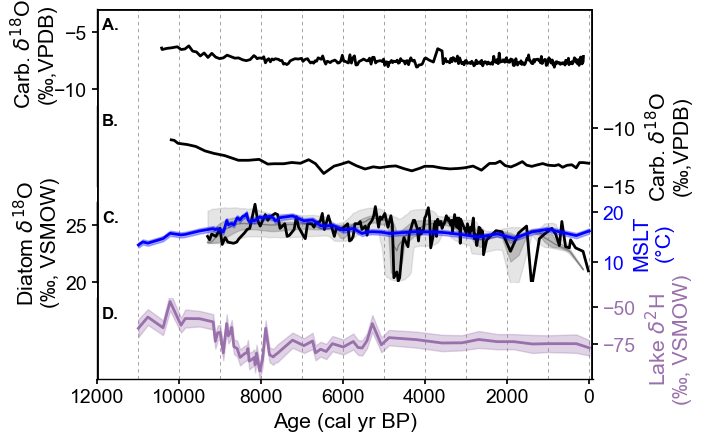

In [41]:
## Example figures using imported LiPD data

# KRL Notes:
# For whatever reason, something in pyleoclim overrides my matplotlib.pyplot figure settings
# i.e. setting its own font size, forcing the dashed grid lines
# can remove the gridlines with 'ax.grid(visible=False)'

fig, axs = plt.subplots(4, 1)

# Get the number of lines
num_lines = 6

# Generate equally spaced colors from 'PRGn' colormap excluding the white color
colors = [cm.PRGn(i / (num_lines - 1)) for i in range(num_lines)]

# Calculate the position for letter label in each subplot
x_pos = 0.01  # Adjust the x-coordinate as needed
y_pos = 0.9   # Adjust the y-coordinate as needed

ax = axs[0]
ax.patch.set_alpha(0)
ax.plot(Soylegrotta.ageMedian, Soylegrotta.paleoData_values,
        linestyle='-', color='black')
ax.set_xlim([12000, -100])
ax.set_ylabel('Carb. $\delta^{18}$O\n(‰,VPDB)')
ax.set_ylim([-10,-3])
ax.grid(visible=False)
ax.set_xticks([])
ax.set_xlabel(None)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_coords(-.08, 0.45)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"A.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')

# Regular line plot of paleoData vs. ageMedian
ax = axs[1]
ax.patch.set_alpha(0)
#tibetanus_18O_ens.common_time(time_axis=tibetanus_18O.ageMedian, bounds_error=False).plot_envelope(ax=ax,
 #                                                                                                  curve_clr='gray',
  #                                                                                                 shade_clr='gray',
   #                                                                                                curve_lw=1,
    #                                                                                               plot_legend=False)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"B.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')

ax.plot(tibetanus_18O.ageMedian, tibetanus_18O.paleoData_values,color='black',zorder=100)
ax.set_xlim([12000, -100])
ax.set_ylim([-15,-8])
ax.set_xlabel('Age (cal yr BP)')
ax.legend([])
ax.grid(visible=False)
ax.set_xticks([])
ax.set_xlabel(None)
ax.set_ylabel('Carb. $\delta^{18}$O\n(‰,VPDB)')
ax.spines['bottom'].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.2, 0.5)

ax = axs[2]
ax.patch.set_alpha(0)
chuna_18O_ens.common_time(time_axis=chuna_18O.ageMedian, bounds_error=False).plot_envelope(ax=ax,
                                                                                           curve_clr='gray',
                                                                                           shade_clr='gray',
                                                                                           curve_lw=1,
                                                                                           plot_legend=False)
ax.plot(chuna_18O.ageMedian, chuna_18O.paleoData_values,color='black',zorder=100)
ax.set_xlim([12000, -100])
ax.set_ylim([20,27])
ax.set_xlabel(None)
ax.set_ylabel('Diatom $\delta^{18}$O\n(‰, VSMOW)')
ax.legend([])
ax.grid(visible=False)
ax.set_xticks([])
ax.set_xlabel(None)
ax.spines['bottom'].set_visible(False)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"C.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')


ax2t=axs[2].twinx()
ax = ax2t
ax.patch.set_alpha(0)
ax.plot(GDGT_temps['ageMedian'][0:65], GDGT_temps['Zhao MBT'][0:65],c='b',label='Imandra')
ax.fill_between(GDGT_temps['ageMedian'][0:65], GDGT_temps['Zhao MBT'][0:65]-.52, GDGT_temps['Zhao MBT'][0:65]+.52,alpha=0.3, edgecolor='b', facecolor='b')
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.08, 0.5)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', labelcolor='b')
ax.set_xlim(12000,-100)
ax.set_ylim(6,22)
ax.grid(visible=False)
ax.set_ylabel('MSLT\n(°C)',c='b')


ax = axs[3]
ax.patch.set_alpha(0)
ax.plot(d2Hwater['ageMedian'][0:60],d2Hwater['d2Hlake'][0:60],c=colors[1],label='Lake')
ax.fill_between(d2Hwater['ageMedian'][0:60], d2Hwater['d2Hlake'][0:60]-d2Hwater['d2Hlake_unc'][0:60], d2Hwater['d2Hlake'][0:60]+d2Hwater['d2Hlake_unc'][0:60],
    alpha=0.3, edgecolor=colors[1], facecolor=colors[1])
ax.set_xlim([12000, -100])
ax.set_xlabel('Age (cal yr BP)')
ax.set_ylabel('Lake $\delta^{2}$H\n(‰, VSMOW)',c=colors[1])
ax.tick_params(axis='y', labelcolor=colors[1])
# ax.set_xticks([])
ax.grid(visible=False)
ax.set_ylim([-99, -44])
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.2, 0.5)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"D.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')

# ax.legend(loc='lower right',bbox_to_anchor=(0.998, 0.85), fontsize='x-small',ncols=2,frameon=True,
#           columnspacing=0.5,borderpad=0.2,borderaxespad=0.2,handletextpad=0.2, handlelength=1)


ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(12000,-100)

#draw a rectangle to highlight specific time span in the plot
#ax_full.axvspan(13000,11400,color='gray',zorder=-1,alpha=0.2) #add this in to draw a single rectangle

#draw vertical dashed lines every 1kyr
for year in range(0, 12000, 1000):
    ax_full.axvline(year, 0, 1, color='k', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)

#draw black lines around the plot
ax_full.axvline(12000,0,1,color='k',zorder=1)
ax_full.axvline(-70,0,1,color='k',zorder=1)
ax_full.axhline(1,12000,-100,color='k',zorder=1)



# Sample code for saving above figure to your working folder
# If you're editing the figures afterwards in Illustrator/Inkscape, make sure you either comment out the second line
# or change the file name after saving. Otherwise, you'll overwrite any of your edits!
example_figure = plt.gcf()
example_figure.savefig('example_figure.pdf')


/Users/elizabeth/anaconda3/envs/pyleo/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


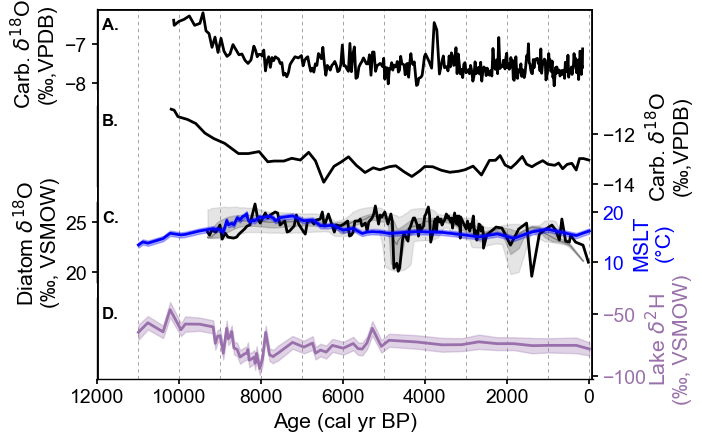

In [142]:
## Example figures using imported LiPD data

# KRL Notes:
# For whatever reason, something in pyleoclim overrides my matplotlib.pyplot figure settings
# i.e. setting its own font size, forcing the dashed grid lines
# can remove the gridlines with 'ax.grid(visible=False)'

fig, axs = plt.subplots(4, 1)

# Get the number of lines
num_lines = 6

# Generate equally spaced colors from 'PRGn' colormap excluding the white color
colors = [cm.PRGn(i / (num_lines - 1)) for i in range(num_lines)]

# Calculate the position for letter label in each subplot
x_pos = 0.01  # Adjust the x-coordinate as needed
y_pos = 0.9   # Adjust the y-coordinate as needed

ax = axs[0]
ax.patch.set_alpha(0)
ax.plot(Soylegrotta.ageMedian, Soylegrotta.paleoData_values,
        linestyle='-', color='black')
ax.set_xlim([12000, -100])
ax.set_ylabel('Carb. $\delta^{18}$O\n(‰,VPDB)')
#ax.set_ylim([-9,-2])
ax.grid(visible=False)
ax.set_xticks([])
ax.set_xlabel(None)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_coords(-.08, 0.45)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"A.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')

# Regular line plot of paleoData vs. ageMedian
ax = axs[1]
ax.patch.set_alpha(0)
# tibetanus_18O_ens.common_time(time_axis=tibetanus_18O.ageMedian, bounds_error=False).plot_envelope(ax=ax,
#                                                                                                    curve_clr='gray',
#                                                                                                    shade_clr='gray',
#                                                                                                    curve_lw=1,
#                                                                                                    plot_legend=False)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"B.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')

ax.plot(tibetanus_18O.ageMedian, tibetanus_18O.paleoData_values,color='black',zorder=100)
ax.set_xlim([12000, -100])
#ax.set_ylim([-15,-8])
ax.set_xlabel('Age (cal yr BP)')
ax.legend([])
ax.grid(visible=False)
ax.set_xticks([])
ax.set_xlabel(None)
ax.set_ylabel('Carb. $\delta^{18}$O\n(‰,VPDB)')
ax.spines['bottom'].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.2, 0.5)

ax = axs[2]
ax.patch.set_alpha(0)
chuna_18O_ens.common_time(time_axis=chuna_18O.ageMedian, bounds_error=False).plot_envelope(ax=ax,
                                                                                           curve_clr='gray',
                                                                                           shade_clr='gray',
                                                                                           curve_lw=1,
                                                                                           plot_legend=False)
ax.plot(chuna_18O.ageMedian, chuna_18O.paleoData_values,color='black',zorder=100)
ax.set_xlim([12000, -100])
ax.set_ylim([19,27])
ax.set_xlabel(None)
ax.set_ylabel('Diatom $\delta^{18}$O\n(‰, VSMOW)')
ax.legend([])
ax.grid(visible=False)
ax.set_xticks([])
ax.set_xlabel(None)
ax.spines['bottom'].set_visible(False)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"C.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')


ax2t=axs[2].twinx()
ax = ax2t
ax.patch.set_alpha(0)
ax.plot(GDGT_temps['ageMedian'][0:65], GDGT_temps['Zhao MBT'][0:65],c='b',label='Imandra')
ax.fill_between(GDGT_temps['ageMedian'][0:65], GDGT_temps['Zhao MBT'][0:65]-.52, GDGT_temps['Zhao MBT'][0:65]+.52,alpha=0.3, edgecolor='b', facecolor='b')
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.08, 0.5)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', labelcolor='b')
ax.set_xlim(12000,-100)
ax.set_ylim(6,22)
ax.grid(visible=False)
ax.set_ylabel('MSLT\n(°C)',c='b')


ax = axs[3]
ax.patch.set_alpha(0)
ax.plot(d2Hwater['ageMedian'][0:60],d2Hwater['d2Hlake'][0:60],c=colors[1],label='Lake')
ax.fill_between(d2Hwater['ageMedian'][0:60], d2Hwater['d2Hlake'][0:60]-d2Hwater['d2Hlake_unc'][0:60], d2Hwater['d2Hlake'][0:60]+d2Hwater['d2Hlake_unc'][0:60],
    alpha=0.3, edgecolor=colors[1], facecolor=colors[1])
ax.set_xlim([12000, -100])
ax.set_xlabel('Age (cal yr BP)')
ax.set_ylabel('Lake $\delta^{2}$H\n(‰, VSMOW)',c=colors[1])
ax.tick_params(axis='y', labelcolor=colors[1])
# ax.set_xticks([])
ax.grid(visible=False)
#ax.set_ylim([-103, -47])
ax.yaxis.tick_right()
ax.yaxis.set_label_coords(1.2, 0.5)
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"D.", transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')

# ax.legend(loc='lower right',bbox_to_anchor=(0.998, 0.85), fontsize='x-small',ncols=2,frameon=True,
#           columnspacing=0.5,borderpad=0.2,borderaxespad=0.2,handletextpad=0.2, handlelength=1)


ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(12000,-100)

#draw a rectangle to highlight specific time span in the plot
#ax_full.axvspan(13000,11400,color='gray',zorder=-1,alpha=0.2) #add this in to draw a single rectangle

#draw vertical dashed lines every 1kyr
for year in range(0, 12000, 1000):
    ax_full.axvline(year, 0, 1, color='k', linestyle=(0, (5, 5)), linewidth=0.5, zorder=1, alpha=0.5)

#draw black lines around the plot
ax_full.axvline(12000,0,1,color='k',zorder=1)
ax_full.axvline(-70,0,1,color='k',zorder=1)
ax_full.axhline(1,12000,-100,color='k',zorder=1)



# Sample code for saving above figure to your working folder
# If you're editing the figures afterwards in Illustrator/Inkscape, make sure you either comment out the second line
# or change the file name after saving. Otherwise, you'll overwrite any of your edits!
example_figure = plt.gcf()
example_figure.savefig('example_figure.pdf')
